# Synthetic Benchmark

```bash
docker run -it ubuntu bash -c "
    echo __1; date +%s%N;
    sleep 2s;
    echo __2; date +%s%N;
    apt-get update;
    echo __3; date +%s%N;
    sleep 2s;
    echo __4; date +%s%N;
    DEBIAN_FRONTEND=noninteractive apt-get install -y tree stress wget;
    echo __5; date +%s%N;
    sleep 2s;
    echo __6; date +%s%N;
    tree;
    echo __7; date +%s%N;
    sleep 2s;
    echo __8; date +%s%N;
    stress --cpu 2 --io 2 --vm 2 --vm-bytes 1024M --timeout 10s;
    echo __9; date +%s%N;
    sleep 2s;
    echo __A; date +%s%N;
    wget \"http://ipv4.download.thinkbroadband.com/10MB.zip\";
    echo __B; date +%s%N;
    sleep 2s
    echo __C; date +%s%N;
" > bench_run_$(date -I)_$(date +"%T.%3N").out
```

In [1]:
import parser

files = parser.get_all_files("./logs/v1", "log")
data = parser.parse_all(files)

Parsing log data from logs/v1/radvisor_2020-03-22_02:20:46.492.log... 

KeyError: 'read'

In [2]:
target_file = './logs/v1/radvisor_2020-03-22_02:20:46.492.log'
entries = data[target_file]
parser.analyze_timestamps(entries)

min_ts = min(e.read for e in entries.values())

def to_s(nano_ts):
    return float(nano_ts - min_ts) / 1E9

KeyError: './logs/v2/dockerd_2020-03-19_21:18:31.521.log'

## Timestamp Deltas

The first plot is a histogram, where a logarithmic scale used on both x and y axes. Almost all deltas are closely clustered around 50ms, with a small amount of outliers.

The second plot is a scatterplot of sequential deltas.

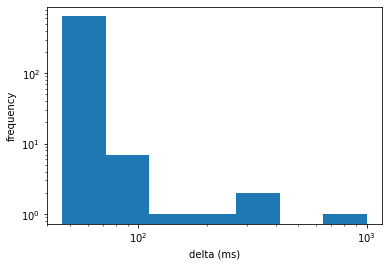

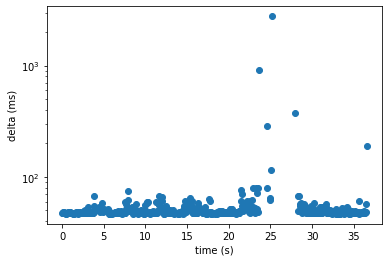

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

d = parser.get_ts_deltas(entries)
deltas = pd.Series(d)
plt.hist(deltas, bins=np.geomspace(deltas.min(), 1000, 8))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("delta (ms)")
plt.ylabel("frequency")
plt.show()

plt.scatter([to_s(e.read) for e in entries.values()][:-1], deltas, marker='o')
plt.yscale('log')
plt.ylabel("delta (ms)")
plt.xlabel("time (s)")
plt.show()

### Period of high deltas

Between timestamp entries 325 and 475, there is a burst of high deltas.

446
516
duration of window: 7.950681273s
lagging % of time: 66.34015676492376%


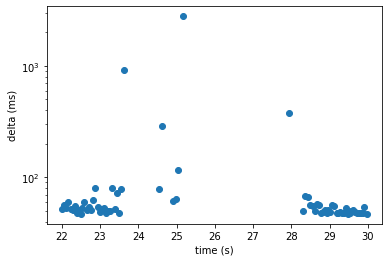

In [58]:
start_s = 22
end_s = 30

ts_list = list(entries.keys())
start = ts_list.index(list(filter(lambda i: to_s(i) > start_s, ts_list))[0])
end = ts_list.index(list(filter(lambda i: to_s(i) > end_s, ts_list))[0])

print(start)
print(end)

entries_window = list(entries.values())[start:end]
window = deltas[start:end]

duration = entries_window[-1].read - entries_window[0].read
print(f"duration of window: {float(duration) / 1E9}s")

above_60 = np.sum([d for d in window if d > 60])
total = np.sum(window)
lag_proportion = (above_60 / total) * 100
print(f"lagging % of time: {lag_proportion}%")

time_series_x = [to_s(e.read) for e in entries_window]
plt.scatter(time_series_x, window, marker='o')
plt.yscale('log')
plt.ylabel("delta (ms)")
plt.xlabel("time (s)")
plt.show()


## CPU Load

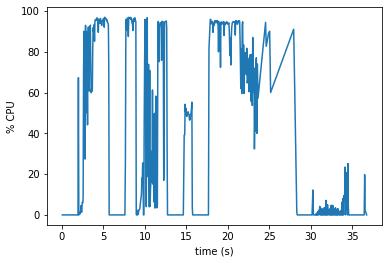

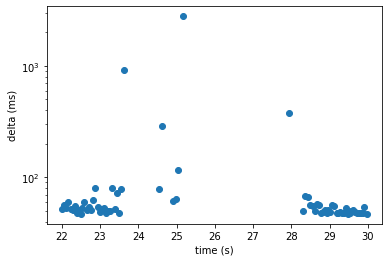

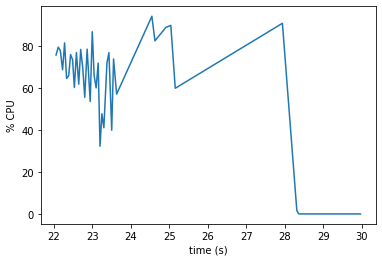

In [59]:
def cpu_per(entry):
    cpu_time = float(entry.cpu.total - entry.pre.cpu.total)
    interval = float(entry.read - entry.pre.read)
    return (cpu_time / interval) * 100

def plot_cpu(entries):
    tail = entries[1:]
    x_series = [to_s(e.read) for e in tail]
    y_series = [cpu_per(e) for e in tail]

    plt.plot(x_series, y_series)
    plt.ylabel("% CPU")
    plt.xlabel("time (s)")
    plt.show()
    
plot_cpu(list(entries.values()))

plt.scatter(time_series_x, window, marker='o')
plt.yscale('log')
plt.ylabel("delta (ms)")
plt.xlabel("time (s)")
plt.show()

plot_cpu(entries_window)